In [1]:
!pip install earthpy gdal seaborn geopandas rasterio lightgbm

In [1]:
from glob import glob
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib as mpl
import seaborn as sns

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import gdal 

import geopandas as gpd
from shapely.geometry import mapping, box

import pandas as pd

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# sns.set_style('white')
# sns.set(font_scale=1.5)      

In [2]:
def show_band(img, title='', size=(6,6), cmap='viridis'):
  # colors = ["g", "yellowgreen",
  #             "peachpuff", "coral", "maroon"]
  # cmap = ListedColormap(colors)
  print(title+' Shape: ', img.shape)
  fig = plt.figure(figsize=size)
  plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap= cmap)
  plt.axis('off')
  plt.colorbar()
  plt.title(title)
  plt.show()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/My Drive/NASA SPACE APP

/content/drive/My Drive/NASA SPACE APP


## prepare Data

In [5]:
all_sentinel_bands = glob(
    "harsha_lake/*B*.jp2")

all_sentinel_bands.sort()
all_sentinel_bands

['harsha_lake/T16SGJ_20160808T162342_B01.jp2',
 'harsha_lake/T16SGJ_20160808T162342_B02.jp2',
 'harsha_lake/T16SGJ_20160808T162342_B03.jp2',
 'harsha_lake/T16SGJ_20160808T162342_B04.jp2',
 'harsha_lake/T16SGJ_20160808T162342_B05.jp2',
 'harsha_lake/T16SGJ_20160808T162342_B06.jp2',
 'harsha_lake/T16SGJ_20160808T162342_B07.jp2',
 'harsha_lake/T16SGJ_20160808T162342_B08.jp2',
 'harsha_lake/T16SGJ_20160808T162342_B09.jp2',
 'harsha_lake/T16SGJ_20160808T162342_B8A.jp2']

In [6]:
# run once, only to generate the RGB composite image.
b4 = rio.open(all_sentinel_bands[3]).read()
b3 = rio.open(all_sentinel_bands[2]).read()
b2 = rio.open(all_sentinel_bands[1]).read()
b8 = rio.open(all_sentinel_bands[7]).read()

In [7]:

with rio.open('harsha_lake/chla.tiff') as f3_af:
  chla = f3_af.read()

with rio.open('harsha_lake/harsha_final.tiff') as f4_gt:
  gt = f4_gt.read()

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Red Band) Shape:  (10980, 10980)


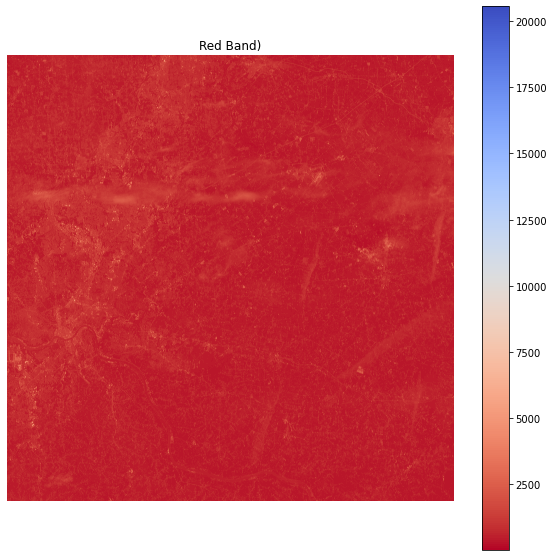

NIR band Shape:  (10980, 10980)


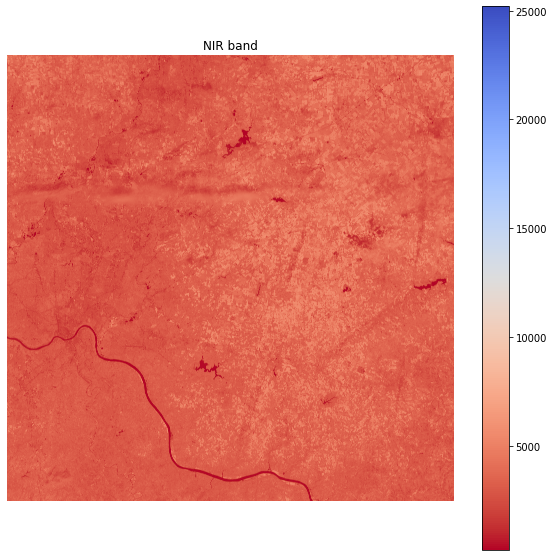

chla Shape:  (500, 1000)


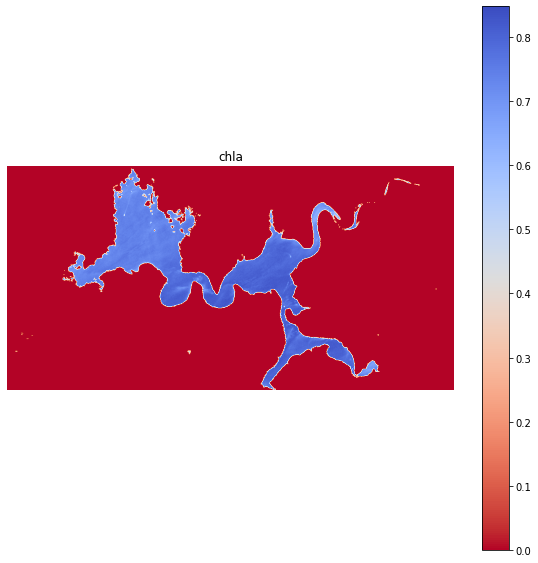

Ground Truth Shape:  (500, 1000)


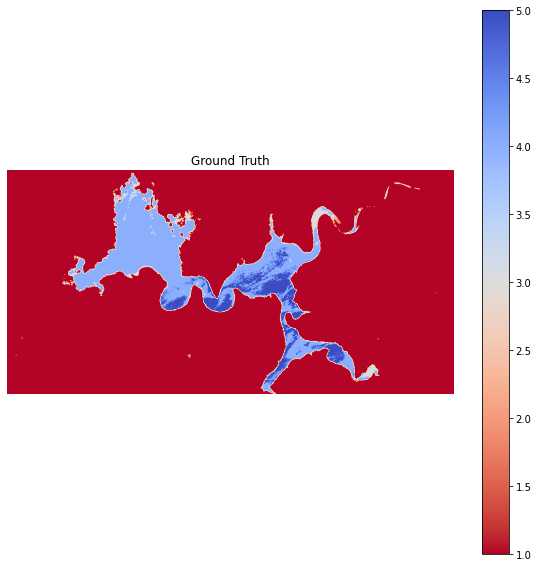

In [8]:
show_band(b4.reshape(b4.shape[1:]), title='Red Band)', size=(10,10), cmap='coolwarm_r')

show_band(b8.reshape(b8.shape[1:]), title='NIR band', size=(10,10), cmap='coolwarm_r')

show_band(chla.reshape(chla.shape[1:]), title='chla', size=(10,10), cmap='coolwarm_r')

show_band(gt.reshape(gt.shape[1:]), title='Ground Truth', size=(10,10), cmap='coolwarm_r')

## Crate a dataset

In [9]:
sz = gt.shape

df = pd.DataFrame(columns=['b2','b3','b4','b8', 'chla', 'groundTruth'])


In [11]:
b2s=[]
b3s=[]
b4s=[]
b8s=[]

In [12]:
for i in range(1):
  for j in range(1):
    for k in range(7500,8000):
      b2s.append(b2[i][k][4500:5500])
      b3s.append(b3[i][k][4500:5500])
      b4s.append(b4[i][k][4500:5500])
      b8s.append(b8[i][k][4500:5500])

In [15]:
b2s=np.array(b2s)
b3s=np.array(b3s)
b4s=np.array(b4s)
b8s=np.array(b8s)
b2s.shape

(500, 1000)

In [17]:
df['b2'] = b2s.astype('float32').ravel()

In [18]:
df['b3'] = b3s.astype('float32').ravel()

In [19]:
df['b4'] = b4s.astype('float32').ravel()

In [20]:
df['b8'] = b8s.astype('float32').ravel()

In [21]:
df['chla'] = chla.reshape(chla.shape[1:]).ravel()


In [22]:
df['groundTruth'] = gt.reshape(gt.shape[1:]).ravel().astype(int)-1

In [23]:
df.head()

,b2,b3,b4,b8,chla,groundTruth
0,841.0,726.0,431.0,3137.0,0.0,0
1,857.0,757.0,446.0,3076.0,0.0,0
2,858.0,778.0,444.0,3141.0,0.0,0
3,849.0,756.0,438.0,3082.0,0.0,0
4,838.0,739.0,436.0,3206.0,0.0,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   b2           500000 non-null  float32
 1   b3           500000 non-null  float32
 2   b4           500000 non-null  float32
 3   b8           500000 non-null  float32
 4   chla         500000 non-null  float32
 5   groundTruth  500000 non-null  int64  
dtypes: float32(5), int64(1)
memory usage: 13.4 MB


In [25]:
df.describe()

,b2,b3,b4,b8,chla,groundTruth
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,863.195801,772.959045,475.077637,2765.667725,0.100978,0.416428
std,116.949287,146.416946,193.047379,1166.472900,0.258269,1.079136
min,730.000000,494.000000,291.000000,233.000000,0.000000,0.000000
25%,804.000000,693.000000,382.000000,2643.000000,0.000000,0.000000
50%,830.000000,732.000000,414.000000,3115.000000,0.000000,0.000000
75%,878.000000,799.000000,474.000000,3427.000000,0.000000,0.000000
max,4683.000000,4599.000000,5078.000000,5749.000000,0.848183,4.000000


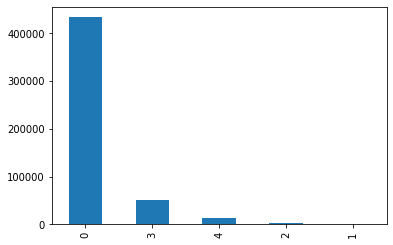

In [26]:
df.groundTruth.value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
# df.to_csv('flood_dataset.csv', index=False)

## Ml Model

we are using **lightbgm**

In [27]:
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns

In [ ]:
# df = pd.read_csv('flood_dataset.csv')

In [28]:
df.head()

,b2,b3,b4,b8,chla,groundTruth
0,841.0,726.0,431.0,3137.0,0.0,0
1,857.0,757.0,446.0,3076.0,0.0,0
2,858.0,778.0,444.0,3141.0,0.0,0
3,849.0,756.0,438.0,3082.0,0.0,0
4,838.0,739.0,436.0,3206.0,0.0,0


In [29]:
x = df.iloc[:, :-1].values

y = df.iloc[:, -1].values

print(f'Data Shape: {x.shape}\nLabel Shape:{y.shape}')

Data Shape: (500000, 5)
Label Shape:(500000,)


In [30]:
#scaling the features using Standard Scaler

sc=StandardScaler()

sc.fit(x)

X=sc.fit_transform(x)

In [31]:
#train_test_split 

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=11, stratify = y)

In [32]:
print(f'X_train Shape:{X_train.shape}\nX_test Shape:{X_test.shape}\ny_train Shape:{y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape:(375000, 5)
X_test Shape:(125000, 5)
y_train Shape:(375000,)
y_test Shape:(125000,)


In [33]:
#converting the dataset into proper LGB format 

d_train=lgb.Dataset(X_train, label=y_train)

In [34]:
#Specifying the parameter

params={}
params['learning_rate']=0.01
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=25
params['num_class']=5 #no.of unique values in the target class not inclusive of the end value

In [35]:
#train the model 

clf = lgb.train(params, d_train, 100)

In [36]:
#prediction on the test set

y_pred = clf.predict(X_test)

In [37]:
#argmax() method 
y_pred = np.array([np.argmax(line) for line in y_pred])

#converting from float to integer
y_pred=y_pred.astype(int)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    108412
           1       1.00      0.96      0.98        54
           2       1.00      0.94      0.97       798
           3       1.00      0.99      1.00     12539
           4       1.00      0.98      0.99      3197

    accuracy                           1.00    125000
   macro avg       1.00      0.98      0.99    125000
weighted avg       1.00      1.00      1.00    125000



In [ ]:
# accuracy_score(y_test, y_pred)

In [39]:
cf_matrix = confusion_matrix(y_test, y_pred)

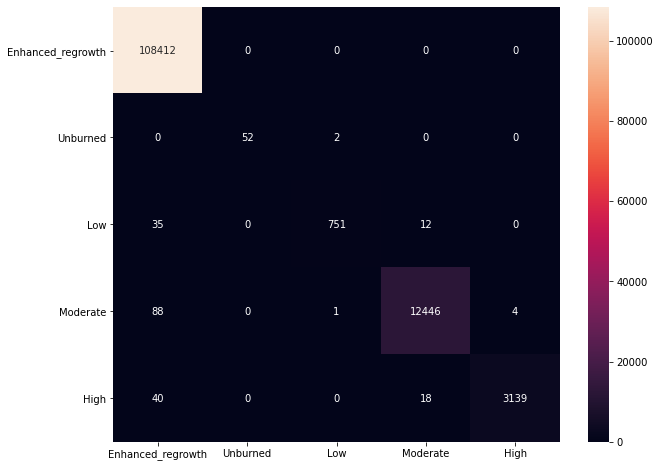

In [40]:
# Confusion Matrix
df_cm = pd.DataFrame(cf_matrix, index = ['Enhanced_regrowth', 'Unburned', 'Low', 'Moderate', 'High'], columns = ['Enhanced_regrowth', 'Unburned', 'Low', 'Moderate', 'High'])

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

In [41]:
clf.save_model('harsha_lake/harsha_model.txt')

## Loading Saved Model

In [42]:
bst = lgb.Booster(model_file='harsha_lake/harsha_model.txt')

In [ ]:
# pred = bst.predict(X_test)

# #argmax() method 
# pred = [np.argmax(line) for line in y_pred]

# #converting from float to integer
# pred=pred.astype(int)

In [ ]:
# print(classification_report(y_test, pred))

In [43]:
f_pred = bst.predict(X)

In [44]:
#argmax() method 
f_pred = np.array([np.argmax(line) for line in f_pred])

#converting from float to integer
f_pred= f_pred.astype(int)

In [45]:
print(classification_report(y, f_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    433650
           1       0.99      0.98      0.98       215
           2       1.00      0.96      0.98      3192
           3       1.00      0.99      1.00     50157
           4       1.00      0.98      0.99     12786

    accuracy                           1.00    500000
   macro avg       1.00      0.98      0.99    500000
weighted avg       1.00      1.00      1.00    500000



In [46]:
y = y + 1
y = y.reshape(gt.shape[1:])

f_pred = f_pred + 1
f_pred = f_pred.reshape(gt.shape[1:])

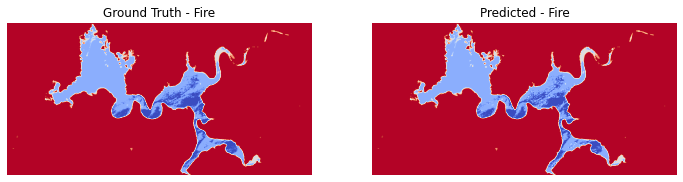

In [47]:
fig = plt.figure(figsize=(12, 20))
ax= fig.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax[0].imshow(y, cmap='coolwarm_r')
ax[0].set_axis_off()
ax[0].title.set_text('Ground Truth - Fire')
ax[1].imshow(f_pred, cmap='coolwarm_r')
ax[1].title.set_text('Predicted - Fire')
ax[1].set_axis_off()
plt.show()

In [48]:
# final Image
f_img = gt.reshape(gt.shape[1:])
f_img = f_pred.reshape(sz)


In [49]:
f_img.shape

(1, 500, 1000)

Predicted Fire Shape:  (500, 1000)


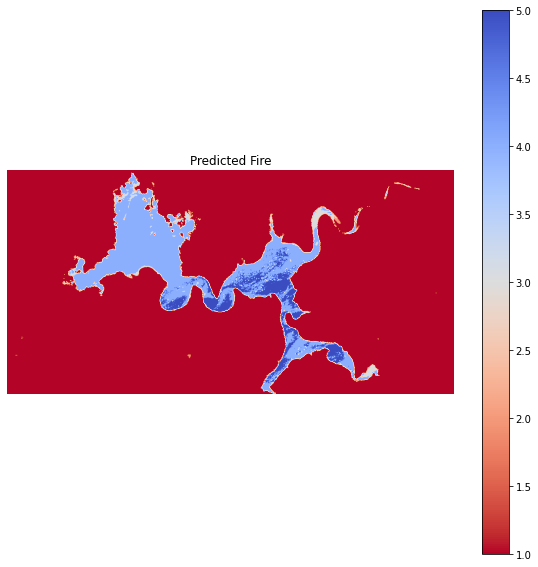

In [50]:
show_band(f_img.reshape(gt.shape[1:]), title='Predicted Fire', size=(10,10), cmap='coolwarm_r')